# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [10]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)

('training label shape:', (2034,))
('test label shape:', (677,))
('dev label shape:', (676,))
('labels names:', ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc'])


(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [3]:
def P1(num_examples=5):
### STUDENT START ###
    for i in range(num_examples):
        print "This text message of Lebal", train_labels[i], "--", newsgroups_train.target_names[train_labels[i]], '\n'
        print train_data[i]
        print "************************"

### STUDENT END ###
P1(5)

This text message of Lebal 1 -- comp.graphics 

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
************************
This text message of Lebal 3 -- talk.religion.misc 



Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Ko

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

**Answer: Size of Vacabulary: 26879; Avg number of nonZero feature: 97; Fraction of nonZero: 0.36%**

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

**Answer: first string: 00; last string: zyxel**

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

**Answer: Avg number of NonZero features: 0.268**

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

**Answer: Size with bi_tri_gram 35478**

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

**Answer: Size with min_df=10: 9490**

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

**Answer: 24.8%**

[6 pts]

In [4]:
def P2():
### STUDENT START ###
    cv = CountVectorizer()
    feature_vectors = cv.fit_transform(train_data)
                    
    print 'a.'
    print 'Shape:', feature_vectors.shape
    print 'Average number of non-zero features per example is', (feature_vectors.nnz)/float(feature_vectors.shape[0])
    print 'Fraction of entries in the matrix that are non-zero is', float(feature_vectors.nnz)/(feature_vectors.shape[0] * feature_vectors.shape[1])*100,'%'
    
    print '\n', 'b.'
    print 'The first (0th) feature string: ', cv.get_feature_names()[0]
    print 'The last feature string: ', cv.get_feature_names()[-1]

    print '\n', 'c.'
    cv2 = CountVectorizer(vocabulary=["atheism","graphics","space","religion"])
    feature_vectors2 = cv2.fit_transform(train_data)
    print 'Shape:', feature_vectors2.shape
    print 'Average number of non-zero features per example is', feature_vectors2.nnz/float(feature_vectors2.shape[0])
    
    print '\n', 'd.'
    cv3 = CountVectorizer(ngram_range =(2,3), analyzer='char')
    bi_tri_gram = cv3.fit_transform(train_data)    
    print 'Shape:', bi_tri_gram.shape
    
    print '\n', 'e.'
    cv4 = CountVectorizer(ngram_range =(2,3), analyzer='char',min_df=10)
    bi_tri_gram = cv4.fit_transform(train_data)    
    print 'Shape:', bi_tri_gram.shape
    
    print '\n', 'f.'
    cv5 = CountVectorizer()
    dev_features = cv5.fit_transform(dev_data)
    missing_words = list(set(cv5.get_feature_names()) - set(cv.get_feature_names()))
    print "Proportion of Missing Words in Dev Data: ", float(len(missing_words))/float(dev_features.shape[1])

### STUDENT END ###
P2()

a.
Shape: (2034, 26879)
Average number of non-zero features per example is 96.7059980334
Fraction of entries in the matrix that are non-zero is 0.359782722696 %

b.
The first (0th) feature string:  00
The last feature string:  zyxel

c.
Shape: (2034, 4)
Average number of non-zero features per example is 0.268436578171

d.
Shape: (2034, 35478)

e.
Shape: (2034, 9490)

f.
Proportion of Missing Words in Dev Data:  0.247876400345


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]

In [14]:
def P3():
### STUDENT START ###
    cv = CountVectorizer()
    train_feature = cv.fit_transform(train_data)
    dev_features = cv.transform(dev_data)
    
    # K-nearest neighbor
    knn = KNeighborsClassifier()
    knn.fit(train_feature, train_labels)
    knn_predict = knn.predict(dev_features)         
    print 'F1 score using default KNN with K=5:', metrics.f1_score(knn_predict, dev_labels, average="macro")
    
    # Find optimal k value using gridSearchCV
    param_grid = {'n_neighbors': list(range(1,100))}
    knn_search = GridSearchCV(estimator=KNeighborsClassifier(),
                               param_grid=param_grid,
                               cv=5,
                               scoring='f1_macro')
    knn_search.fit(train_feature,train_labels)
    print 'Best KNN with', knn_search.best_params_, 'F1: ', knn_search.best_score_
    
    print '\n'
    # Multinomial Naive Bayes 
    mnb = MultinomialNB()
    mnb.fit(train_feature, train_labels)
    mnb_pred = mnb.predict(dev_features)
    print 'F1 score using default MulitnomialNB alpha=1:', metrics.f1_score(mnb_pred,dev_labels, average='macro')

    # Find optimal alpha for MultinomialNB
    alphas = {'alpha': [0.0001,0.001,0.01,0.1,1,10]}
    mnb_search = GridSearchCV(estimator = MultinomialNB(), 
                              param_grid=alphas,
                              cv=5,
                              scoring='f1_macro')
    mnb_search.fit(train_feature, train_labels)  
    print 'Best MulitnomialNB with ', mnb_search.best_params_, 'F1:', mnb_search.best_score_
    
    print '\n'
    # Logistic regression
    log_reg = LogisticRegression(penalty='l2')
    log_reg.fit(train_feature, train_labels)
    log_reg_pred = log_reg.predict(dev_features)
    print 'F1 score using default Logistic Regression:', metrics.f1_score(log_reg_pred, dev_labels, average='macro')

    # Find the best regularization parameter for logistic regression
    regC = {'C': [0.001,0.01,1.0,1.5,3.0,4.5,10.0,20.0,30.0,100.0,1000.0]}
    log_reg_search = GridSearchCV(estimator = LogisticRegression(),
                                  param_grid=regC,
                                  scoring='f1_macro')
    log_reg_search.fit(train_feature, train_labels)    
    print 'Best Logistic Regression score with ',log_reg_search.best_params_, 'F1: ', log_reg_search.best_score_     

    # Output the sum of the squared weight values for each class for each setting of the C parameter
    print '\n'
    coefficients = []
    regC = [0.001,0.01,1.0,1.5,3.0,4.5,10.0,20.0,30.0,100.0]
    for i in regC:
        log_reg = LogisticRegression(C=i)
        log_reg.fit(train_feature,train_labels)
        log_pred = log_reg.predict(dev_features)
        coefficients.append(log_reg.coef_)

    print 'Output the sum of the squared weight values for each class for each setting of the C parameter: \n'
    for j in range(len(coefficients)):
        sq = np.square(coefficients[j])
        print 'C =', str(regC[j]), np.sum(sq,axis=1)
### STUDENT END ###
P3()

F1 score using default KNN with K=5: 0.4146398917578007
Best KNN with {'n_neighbors': 20} F1:  0.436253268641


F1 score using default MulitnomialNB alpha=1: 0.7578687619026611
Best MulitnomialNB with  {'alpha': 0.01} F1: 0.81642343928


F1 score using default Logistic Regression: 0.681318340101208
Best Logistic Regression score with  {'C': 3.0} F1:  0.746237697703


Output the sum of the squared weight values for each class for each setting of the C parameter: 

C = 0.001 [0.16509345 0.20095275 0.18067094 0.18724278]
C = 0.01 [2.54153107 2.93970937 2.86246609 2.25002889]
C = 1.0 [166.99162461 130.90838218 157.9974861  145.73565689]
C = 1.5 [216.57155332 167.57644941 202.82733977 189.78697209]
C = 3.0 [323.884252   247.78948127 299.91796783 286.88018107]
C = 4.5 [401.12913989 306.21630735 369.88552094 357.58924135]
C = 10.0 [586.45510122 449.07426402 539.30767308 530.74698461]
C = 20.0 [785.87807443 606.04030145 723.53660477 721.43368424]
C = 30.0 [920.5403126  709.80007741 848.3931904

ANSWER:
a. Why doesn't nearest neighbors work well for this problem?

**Nearest neighbor classifiers do not work well when there are too many features and with such a sparse matrix constructed by cv. Moreover, there is the added complexity that words in the english language do not have a standard "distance" from each other where the knowledge of English language is needed to determind if the two sentences have similiar meaning aka close distance in knn.**

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

**Logistic regression does not work as well in this situation because there are many more features than training examples, thus logistic regression overfit the model because it incorporated correlations between the features into the prediction. Naive Bayes classifier assumes independence between features and thus does not have the same problem.**

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

**Based on the output above, the value of C is the inverse of regularization strength, so smaller values represent stronger regularization. Regularization is the concept of penalizing larger parameter values to prevent overfitting. As C gets larger in value, the size of the parameters of the logistic regression model will increase in magnitude to adjust to the training data.**

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [6]:
def P4():
### STUDENT START ###
    # Find 5 features with largest (absolute value) weights for each label, unigram features
    cv = CountVectorizer()
    train_feature = cv.fit_transform(train_data)
    dev_features = cv.transform(dev_data)
    feature_names = cv.get_feature_names()

    # Using best C parameter from P3 to fit Logistic Reg
    log_reg = LogisticRegression(C=3)
    log_reg.fit(train_feature, train_labels)
    
    indexes = np.argpartition(np.absolute(log_reg.coef_), -5)[:,-5:].flatten()
    values = np.take(log_reg.coef_, indexes, axis=1)
    names = [cv.get_feature_names()[idx].encode('utf8') for idx in indexes]
    target_names = []
    for name in newsgroups_train.target_names:
        target_names.append(name)
    target_names = target_names*5
    target_names.sort()
    v = np.transpose(values)
    print '5 unigram features with largest (absolute) weights for each label: \n'
    for i in range(len(v)):
        print v[i], names[i], ':', target_names[i]

    # Find 5 features with largest (absolute value) weights for each label, bigram features
    print '\n'
    cv = CountVectorizer(ngram_range =(2, 2), analyzer='word')
    train_feature = cv.fit_transform(train_data)
    dev_features = cv.transform(dev_data)
    feature_names = cv.get_feature_names()
    log_reg = LogisticRegression(C=3)
    log_reg.fit(train_feature, train_labels)
    
    indexes = np.argpartition(np.absolute(log_reg.coef_), -5)[:,-5:].flatten()
    values = np.take(log_reg.coef_, indexes, axis=1)
    names = [cv.get_feature_names()[idx].encode('utf8') for idx in indexes]
    v = np.transpose(values)
    print '5 bigram features with largest (absolute) weights for each label: \n'
    for i in range(len(v)):
        print v[i], names[i], ':', target_names[i]

### STUDENT END ###
P4()

5 unigram features with largest (absolute) weights for each label: 

[ 1.22510526 -0.80749166 -1.02868622 -0.06351363] religion : alt.atheism
[ 1.27238906 -0.26707564 -0.42260714 -0.5943199 ] bobby : alt.atheism
[ 2.02081559 -0.79401825 -0.80281032 -0.73539556] deletion : alt.atheism
[-1.59818229 -1.64677565  2.68011625 -1.52149989] space : alt.atheism
[ 1.37401583 -0.10181587 -0.40823182 -1.18584508] atheists : alt.atheism
[-0.44668006  1.42954201 -0.92811481 -0.47862259] 3d : comp.graphics
[-0.45610151  1.60921135 -1.01533316 -0.85737321] file : comp.graphics
[-1.59818229 -1.64677565  2.68011625 -1.52149989] space : comp.graphics
[-0.78912223  1.7302415  -1.08874768 -0.63381076] image : comp.graphics
[-0.96832353  2.47964706 -1.74231349 -1.01741517] graphics : comp.graphics
[-0.45376917 -0.51993718  1.22946753 -0.54932815] spacecraft : sci.space
[-0.76334362 -0.59028252  1.29425477 -0.57539732] nasa : sci.space
[-0.96832353  2.47964706 -1.74231349 -1.01741517] graphics : sci.space
[-

ANSWER:

**For the unigram table, "space" was a common feature for every label. This leads me to believe there will be a lot of false-positives when the 'space' feature is present. For the bigram table, 'cheers kent' appeared in space, atheism and computer graphics. This feature is not quite topic specific. Maybe due to coincidence.**

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [7]:
def better_preprocessor(s):
### STUDENT START ###
    lowercase = s.lower()
    number_token = re.sub(r'\d+','numholder', lowercase)
    letters_only = re.sub("[^a-zA-Z]", " ", number_token)
    no_shortwords = re.sub(r'\W*\b\w{1,3}\b', " ", letters_only)
    
    return no_shortwords
### STUDENT END ###

def P5():
### STUDENT START ###
    # Default CountVectorizer with LogisticRegression
    cv = CountVectorizer()
    default_cv = cv.fit_transform(train_data)
    dev_features = cv.transform(dev_data)
    log_reg = LogisticRegression()
    log_reg.fit(default_cv, train_labels)
    pred = log_reg.predict(dev_features)
    print default_cv.shape
    default_f1 = metrics.f1_score(pred, dev_labels, average='macro')
    print 'The F1 score without preprocessing:', default_f1

    # Applying better preprocessor
    print '\n'
    cv2 = CountVectorizer(preprocessor=better_preprocessor)
    better_features = cv2.fit_transform(train_data)
    log_reg.fit(better_features, train_labels)
    dev_features = cv2.transform(dev_data)
    pred = log_reg.predict(dev_features)
    print better_features.shape
    new_f1 = metrics.f1_score(pred, dev_labels, average='macro')
    print 'The F1 score with better preprocessing:', new_f1
    
    print '\n'
    print 'F1 score improved by', new_f1 - default_f1
    print 'Vocabulary was reduced by', default_cv.shape[1] - better_features.shape[1]
### STUDENT END ###
P5()

(2034, 26879)
The F1 score without preprocessing: 0.681318340101208


(2034, 22474)
The F1 score with better preprocessing: 0.6977953562124706


F1 score improved by 0.01647701611126262
Vocabulary was reduced by 4405


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

C = 0.001
Number of non-zero weights with L1 penalty: 5
Number of non-zero weights with L2 penalty: 107516
L1 penalty results in vocab that is 0.0 the size of L2
C = 0.01
Number of non-zero weights with L1 penalty: 36
Number of non-zero weights with L2 penalty: 107516
L1 penalty results in vocab that is 0.0 the size of L2
C = 0.1
Number of non-zero weights with L1 penalty: 363
Number of non-zero weights with L2 penalty: 107516
L1 penalty results in vocab that is 0.003 the size of L2
C = 0.25
Number of non-zero weights with L1 penalty: 757
Number of non-zero weights with L2 penalty: 107516
L1 penalty results in vocab that is 0.007 the size of L2
C = 0.5
Number of non-zero weights with L1 penalty: 1208
Number of non-zero weights with L2 penalty: 107516
L1 penalty results in vocab that is 0.011 the size of L2
C = 0.75
Number of non-zero weights with L1 penalty: 1589
Number of non-zero weights with L2 penalty: 107516
L1 penalty results in vocab that is 0.015 the size of L2
C = 1.0
Number o

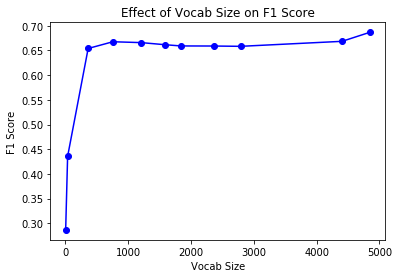

In [12]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    C_values =  [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.5, 5.0, 10.0]
    vocab_size = []
    f1_scores = []  
    cv = CountVectorizer()
    train_features = cv.fit_transform(train_data)
    dev_features = cv.transform(dev_data)
    feature_names = cv.get_feature_names()
    
    for c in C_values:
        print 'C =', c
        log_reg_l1 = LogisticRegression(penalty='l1', C=c, tol=0.01)
        log_reg_l1.fit(train_features, train_labels)
        non_zero_weights = np.argwhere(log_reg_l1.coef_!=0)
        print 'Number of non-zero weights with L1 penalty:', non_zero_weights.shape[0]
        vocab_size.append(non_zero_weights.shape[0])
        
        log_reg_l2 = LogisticRegression(penalty='l2', C=c, tol=0.01)
        log_reg_l2.fit(train_features, train_labels)
        non_zero_weights_l2 = np.argwhere(log_reg_l2.coef_!=0)
        print 'Number of non-zero weights with L2 penalty:', non_zero_weights_l2.shape[0]
        print 'L1 penalty results in vocab that is', round(non_zero_weights.shape[0]/float(non_zero_weights_l2.shape[0]),3), 'the size of L2'

        # Reduce the size of the vocabulary by keeping only features that have at least one non-zeo weight
        vocab_idx = np.unique(non_zero_weights[:,-1])
        new_vocab = []
        for i in vocab_idx:
            new_vocab.append(feature_names[i])

        # Retrain a model using L2
        cv2 = CountVectorizer(vocabulary=new_vocab)
        train_features2 = cv2.fit_transform(train_data)
        dev_features2 = cv2.transform(dev_data)
        log_reg_l2 = LogisticRegression(penalty='l2', C=c, tol=0.01)
        log_reg_l2.fit(train_features2, train_labels)
        pred = log_reg_l2.predict(dev_features2)
        f1_scores.append(metrics.f1_score(pred, dev_labels, average='macro'))

    plt.plot(vocab_size, f1_scores, 'b-o')
    plt.title('Effect of Vocab Size on F1 Score')  
    plt.ylabel('F1 Score') 
    plt.xlabel('Vocab Size') 
    plt.show()
    

    ### STUDENT END ###
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [11]:
def P7():
### STUDENT START ###
    tfidf = TfidfVectorizer()
    train_features = tfidf.fit_transform(train_data)
    dev_features = tfidf.transform(dev_data)
    log_reg = LogisticRegression(C=100)
    log_reg.fit(train_features, train_labels)
    pred = log_reg.predict(dev_features)
    print 'F1 Score:', metrics.f1_score(pred, dev_labels, average='macro')
    
    # determine the r ratio = maximum predicted probability / predicted probability of the correct label
    pred_prob = log_reg.predict_proba(dev_features)
    max_pred_prob = np.amax(pred_prob, axis=1)
    
    
    correct_pred_prob = []
    for i in range(pred_prob.shape[0]):
        correct_pred_prob.append(pred_prob[i, dev_labels[i]])

    r_ratio = max_pred_prob / correct_pred_prob
    
    top_3_r_idx = np.argpartition(r_ratio, -3)[-3:]
    top_3_r = np.take(r_ratio, top_3_r_idx)
    print 'Top 3 R scores:', top_3_r
    
    for i in top_3_r_idx:
        print dev_data[i], '\n'
        print 'Predicted:', pred[i], ':', newsgroups_train.target_names[pred[i]]
        print 'Actual:', dev_labels[i], ':', newsgroups_train.target_names[dev_labels[i]]
        print '************************************************************** \n'
    
    
### STUDENT END ###
P7()

F1 Score: 0.7473913101645842
Top 3 R scores: [287.17912766 325.00382264 929.35599009]

The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...


Predicted: 3 : talk.religion.misc
Actual: 0 : alt.atheism
************************************************************** 

Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible. 

Predicted: 1 : comp.graphics
Actual: 3 : talk.religion.misc
************************************************************** 

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have bee

ANSWER:

**The goal of using tf-idf is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.**

**The use of computer jargon in otherwise religious posts seems to confuse the classifier. For example "ftp" is used in both example. A way to potentially fix incorrectly predicting 'computer graphics' when something else could be to include some basic internet stopwords, such as 'internet', 'ftp' and various non-graphic file types, e.g. 'RTF', but retain graphics file types, e.g. 'PNG'.**

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance